[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Pearson Correlation (Polynomial Regression) = 0.8823


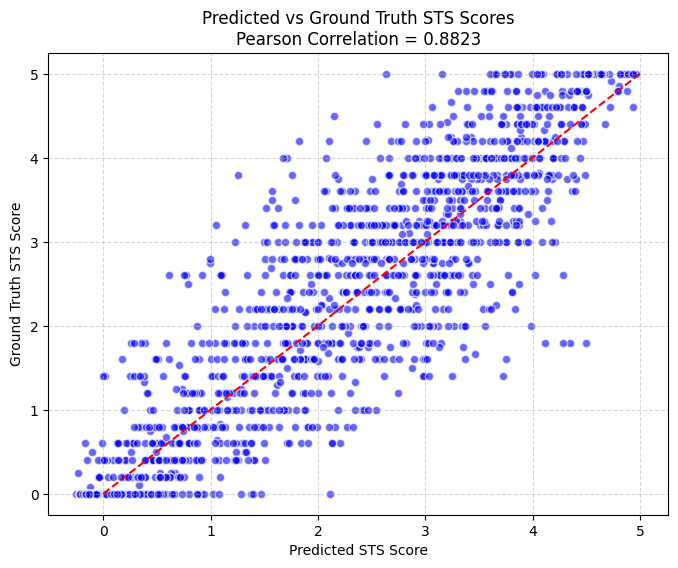

In [2]:
import csv
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from sentence_transformers import SentenceTransformer

# Ensure required NLTK data is downloaded
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

# Paths to data files
train_file = "./data/sts-train.csv" #"/content/data/sts-train.csv"
test_file = "./data/sts-dev.csv"  #"/content/data/sts-dev.csv"

###############################################################################
# 1. Utility Functions
###############################################################################
def load_sts_data_tsv(file_path):
    """
    Loads STS data from a tab-separated file.
    Returns: sents1, sents2, scores
    """
    sents1, sents2, scores = [], [], []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        for row_idx, row in enumerate(reader):
            if len(row) < 7:  # Skip rows with insufficient data
                continue
            try:
                scores.append(float(row[4]))
                sents1.append(row[5])
                sents2.append(row[6])
            except ValueError:
                print(f"Skipping line {row_idx} due to parse error: {row}")
    return sents1, sents2, scores

def preprocess_text(text):
    """
    Preprocess text by lowercasing, removing stopwords, punctuation, and applying stemming.
    """
    stop_words = set(stopwords.words('english'))
    punct_set = set(string.punctuation)
    stemmer = PorterStemmer()

    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [
        stemmer.stem(token) for token in tokens
        if token not in stop_words and token not in punct_set
    ]
    return ' '.join(filtered_tokens)

def compute_tfidf_similarities(sents1, sents2, vectorizer):
    """
    Compute TF-IDF cosine similarity between two lists of sentences.
    """
    sims = []
    for s1, s2 in zip(sents1, sents2):
        v1 = vectorizer.transform([s1])
        v2 = vectorizer.transform([s2])
        sims.append(cosine_similarity(v1, v2)[0][0])
    return sims

def compute_semantic_similarities(sents1, sents2, model):
    """
    Compute cosine similarity using sentence embeddings.
    """
    all_sentences = sents1 + sents2
    embeddings = model.encode(all_sentences, batch_size=32, show_progress_bar=False)
    n = len(sents1)
    return [
        cosine_similarity(embeddings[i].reshape(1, -1), embeddings[i + n].reshape(1, -1))[0][0]
        for i in range(n)
    ]

def compute_common_words_count(sents1, sents2):
    """
    Compute the count of common words between sentence pairs.
    """
    return [len(set(s1.split()) & set(s2.split())) for s1, s2 in zip(sents1, sents2)]

def compute_jaccard_similarity(sents1, sents2):
    """
    Compute Jaccard similarity between sentence pairs.
    """
    sims = []
    for s1, s2 in zip(sents1, sents2):
        set1, set2 = set(s1.split()), set(s2.split())
        intersection = set1 & set2
        union = set1 | set2
        sims.append(len(intersection) / len(union) if union else 0.0)
    return sims

###############################################################################
# 2. Data Loading and Preprocessing
###############################################################################
train_sents1, train_sents2, train_scores = load_sts_data_tsv(train_file)
test_sents1, test_sents2, test_scores = load_sts_data_tsv(test_file)

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

# Preprocess sentences
preproc_train_sents1 = [preprocess_text(s) for s in train_sents1]
preproc_train_sents2 = [preprocess_text(s) for s in train_sents2]
preproc_test_sents1 = [preprocess_text(s) for s in test_sents1]
preproc_test_sents2 = [preprocess_text(s) for s in test_sents2]

###############################################################################
# 3. Feature Engineering
###############################################################################
# Fit TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2), max_features=5000)
vectorizer.fit(preproc_train_sents1 + preproc_train_sents2)

# Compute similarities
train_syn_sim = compute_tfidf_similarities(preproc_train_sents1, preproc_train_sents2, vectorizer)
test_syn_sim = compute_tfidf_similarities(preproc_test_sents1, preproc_test_sents2, vectorizer)

# Load SentenceTransformer model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
train_sem_sim = compute_semantic_similarities(train_sents1, train_sents2, model)
test_sem_sim = compute_semantic_similarities(test_sents1, test_sents2, model)

# Compute additional features
train_common_words = compute_common_words_count(preproc_train_sents1, preproc_train_sents2)
test_common_words = compute_common_words_count(preproc_test_sents1, preproc_test_sents2)

train_jaccard_sim = compute_jaccard_similarity(preproc_train_sents1, preproc_train_sents2)
test_jaccard_sim = compute_jaccard_similarity(preproc_test_sents1, preproc_test_sents2)

# Combine all features
X_train = np.column_stack([train_syn_sim, train_sem_sim, train_common_words, train_jaccard_sim])
X_test = np.column_stack([test_syn_sim, test_sem_sim, test_common_words, test_jaccard_sim])

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

###############################################################################
# 4. Model Training and Evaluation
###############################################################################
# Train polynomial regression model
reg_poly = LinearRegression()
reg_poly.fit(X_train_poly, train_scores)

# Predict and evaluate
y_pred_poly = reg_poly.predict(X_test_poly)
pearson_corr_poly, _ = pearsonr(y_pred_poly, test_scores)
print(f"Pearson Correlation (Polynomial Regression) = {pearson_corr_poly:.4f}")

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_poly, test_scores, alpha=0.6, color='blue', edgecolors='w')
plt.plot([0, 5], [0, 5], 'r--')
plt.xlabel("Predicted STS Score")
plt.ylabel("Ground Truth STS Score")
plt.title(f"Predicted vs Ground Truth STS Scores\nPearson Correlation = {pearson_corr_poly:.4f}")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
